<a href="https://colab.research.google.com/github/victorfiz/ucl_ml/blob/main/k_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

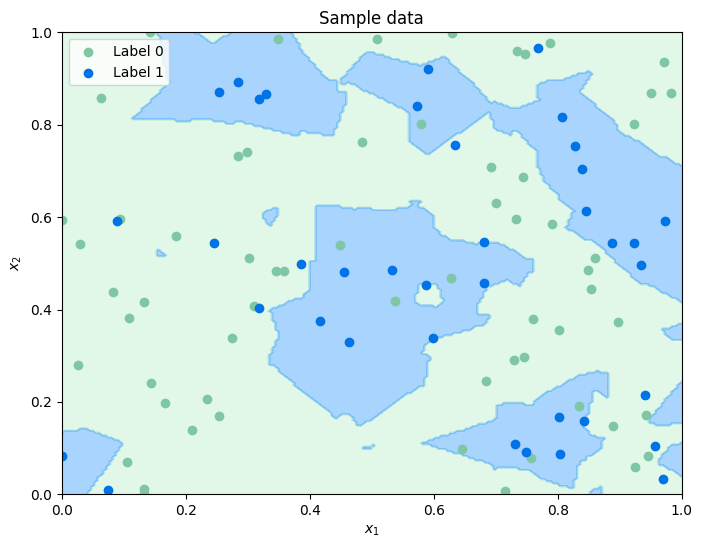

In [2]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Custom k-NN classifier in JAX
class MyKNeighborsClassifierJAX:
    def __init__(self, n_neighbors=3):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        """
        Predict labels for the given points X using the k-NN model.
        """
        def predict_single(x):
            distances = jnp.linalg.norm(self.X_train - x, axis=1)
            nearest_neighbors = jnp.argsort(distances)[:self.n_neighbors]
            labels = self.y_train[nearest_neighbors]
            return jnp.where(jnp.sum(labels) > self.n_neighbors / 2, 1, 0)

        return jax.vmap(predict_single)(X)

# Generate random data points and labels
def sample_S(rng, S_size=100):
    X = jax.random.uniform(rng, (S_size, 2))
    y = jax.random.bernoulli(rng, 0.5, (S_size,))
    return X, y

# Visualise decision boundary
def plot_decision_boundary(model, X_train, y_train, n=200):
    xx, yy = jnp.meshgrid(jnp.linspace(0, 1, n), jnp.linspace(0, 1, n))
    grid_points = jnp.c_[xx.ravel(), yy.ravel()]

    Z = model.predict(grid_points)
    Z = Z.reshape(xx.shape)

    custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#D6F8D6", "#66b3ff"])
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.6, cmap=custom_cmap)
    plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], c='#7FC6A4', label='Label 0')
    plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], c='#0073e6', label='Label 1')
    plt.title('Sample data')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend()
    plt.show()

# Initialise parameters
rng = jax.random.PRNGKey(0)
S_size = 100
v = 3  # Number of nearest neighbours

# Generate dataset
rng, rng_sample = jax.random.split(rng)
X_train, y_train = sample_S(rng_sample, S_size)

# Instantiate and fit k-NN classifier
knn = MyKNeighborsClassifierJAX(n_neighbors=v)
knn.fit(X_train, y_train)

# Plot the decision boundary
plot_decision_boundary(knn, X_train, y_train)


In [4]:
import jax.numpy as jnp
import jax
from tqdm import tqdm
import matplotlib.pyplot as plt

# Function to sample S
def sample_S(rng):
    X = jax.random.uniform(rng, (2, 100))
    Y = jax.random.bernoulli(rng, 0.5, (100,))
    return X, Y

# Function to create hsv map
def calc_hsv(x, X, Y, v=3):
    """
    x: (2,)
    X: (2, n)
    Y: (n,)
    """
    distances = jnp.linalg.norm(X - x[:, None], axis=0)
    nearest_neighbours = jnp.argsort(distances)
    v_nearest = nearest_neighbours[:v]  # v=3
    labels = Y[v_nearest]

    return jnp.where(jnp.sum(labels) > v / 2, 1, 0)

# Generate HSV function from S
def get_hsv_fun(S_X, S_Y):
    return lambda x: calc_hsv(x, S_X, S_Y)

# Function to generate data from p_h(x, y)
def generate_data(rng, n_samples, hsv):
    """
    rng: PRNGKey
    n_samples: int
    hsv: function
    """
    rng_x, rng_flip, rng_rand, rng = jax.random.split(rng, 4)

    x = jax.random.uniform(rng_x, (2, n_samples))

    y_flip = jax.random.bernoulli(rng_flip, 0.8, (n_samples,))  # 0 or 1
    y_rand = jax.random.bernoulli(rng_rand, 0.5, (n_samples,))  # Random flip

    y = y_flip * jax.vmap(hsv, in_axes=1)(x) + (1 - y_flip) * y_rand

    return x, y

# Function to build k-NN model
def build_knn_model(x_train, y_train, k):
    """
    x_train: (2, n)
    y_train: (n,)
    k: int
    """
    def predict(x):
        distances = jnp.linalg.norm(x_train - x[:, None], axis=0)
        nearest_neighbours = jnp.argsort(distances)
        v_nearest = nearest_neighbours[:k]
        labels = y_train[v_nearest]

        return jnp.where(jnp.sum(labels) > k / 2, 1, 0)

    return predict

# Inner loop of the experiment
def inner_loop(rng, k):
    rng_S, rng_train, rng_test, rng = jax.random.split(rng, 4)

    # Sample S and get hsv function
    S_X, S_Y = sample_S(rng_S)
    hsv = get_hsv_fun(S_X, S_Y)

    # Generate training data
    x_train, y_train = generate_data(rng_train, 4000, hsv)

    # Build and JIT-compile k-NN model
    knn_model = build_knn_model(x_train, y_train, k)
    jitted_knn_model = jax.jit(knn_model)

    # Generate test data
    x_test, y_test = generate_data(rng_test, 1000, hsv)

    # Predict using the k-NN model
    y_pred = jax.vmap(jitted_knn_model, in_axes=1)(x_test)

    # Calculate accuracy and generalisation error
    accuracy = jnp.mean(y_pred == y_test)
    generalisation_error = 1 - accuracy

    return generalisation_error

# JIT and vmap optimization
jitted_inner_loop = jax.jit(inner_loop, static_argnums=(1,))
vmapped_inner_loop = jax.vmap(inner_loop, in_axes=(0, None))

# Experimental protocol
n_trials = 100
max_k = 49
generalisation_errors = []

rng = jax.random.PRNGKey(0)
for k in tqdm(range(1, max_k + 1), desc="k-values progress"):
    rng_list = jax.random.split(rng, n_trials + 1)
    ge = vmapped_inner_loop(jnp.array(rng_list[:-1]), k)
    generalisation_errors.append(ge.mean())


k-values progress: 100%|██████████| 49/49 [01:07<00:00,  1.38s/it]


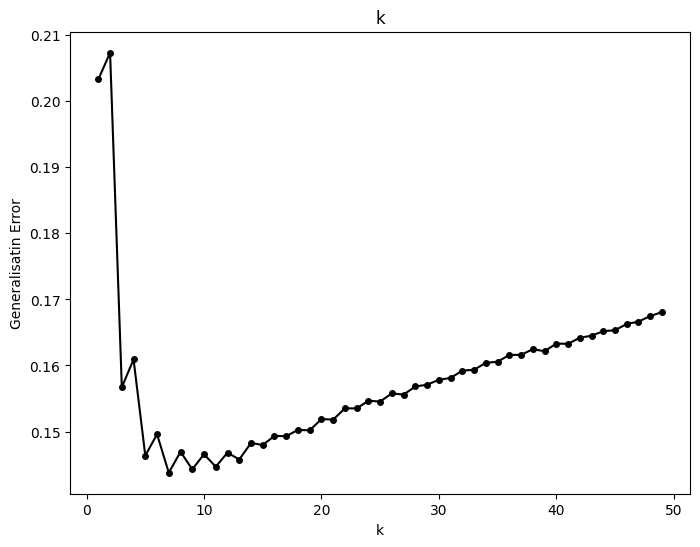

In [5]:
# Plotting generalisation error with original style
plt.figure(figsize=(8, 6))
plt.plot(range(1, max_k + 1), generalisation_errors, marker='o', markersize=4, color='black')
plt.xlabel('k')
plt.ylabel('Generalisatin Error')
plt.title('k')
plt.grid(False)
plt.show()

Training sizes (m): 100%|██████████| 9/9 [04:24<00:00, 29.39s/it]


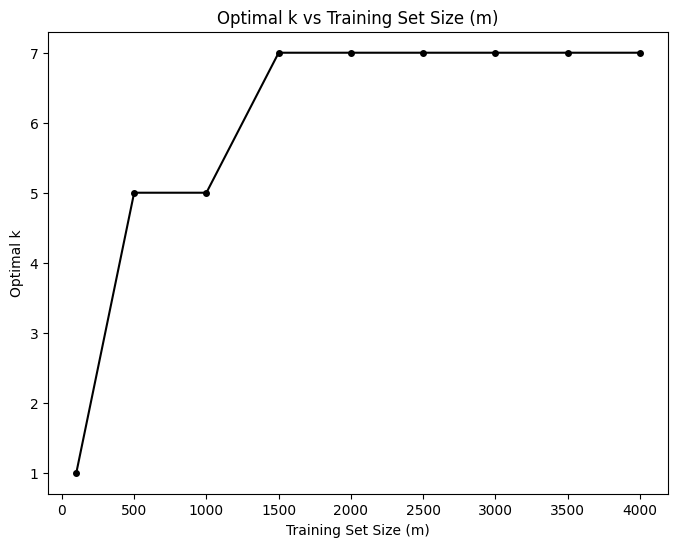

In [3]:
import jax.numpy as jnp
import jax
from tqdm import tqdm
import matplotlib.pyplot as plt

# Function to sample S
def sample_S(rng):
    X = jax.random.uniform(rng, (2, 100))
    Y = jax.random.bernoulli(rng, 0.5, (100,))
    return X, Y

# Function to create hsv map
def calc_hsv(x, X, Y, v=3):
    distances = jnp.linalg.norm(X - x[:, None], axis=0)
    nearest_neighbours = jnp.argsort(distances)
    v_nearest = nearest_neighbours[:v]
    labels = Y[v_nearest]
    return jnp.where(jnp.sum(labels) > v / 2, 1, 0)

# Generate HSV function from S
def get_hsv_fun(S_X, S_Y):
    return lambda x: calc_hsv(x, S_X, S_Y)

# Function to generate data from p_h(x, y)
def generate_data(rng, n_samples, hsv):
    rng_x, rng_flip, rng_rand, rng = jax.random.split(rng, 4)
    x = jax.random.uniform(rng_x, (2, n_samples))
    y_flip = jax.random.bernoulli(rng_flip, 0.8, (n_samples,))
    y_rand = jax.random.bernoulli(rng_rand, 0.5, (n_samples,))
    y = y_flip * jax.vmap(hsv, in_axes=1)(x) + (1 - y_flip) * y_rand
    return x, y

# Function to build k-NN model
def build_knn_model(x_train, y_train, k):
    def predict(x):
        distances = jnp.linalg.norm(x_train - x[:, None], axis=0)
        nearest_neighbours = jnp.argsort(distances)
        v_nearest = nearest_neighbours[:k]
        labels = y_train[v_nearest]
        return jnp.where(jnp.sum(labels) > k / 2, 1, 0)
    return predict

# Inner loop of the experiment
def inner_loop(rng, k, m):
    rng_S, rng_train, rng_test, rng = jax.random.split(rng, 4)
    S_X, S_Y = sample_S(rng_S)
    hsv = get_hsv_fun(S_X, S_Y)
    x_train, y_train = generate_data(rng_train, m, hsv)
    knn_model = build_knn_model(x_train, y_train, k)
    jitted_knn_model = jax.jit(knn_model)
    x_test, y_test = generate_data(rng_test, 1000, hsv)
    y_pred = jax.vmap(jitted_knn_model, in_axes=1)(x_test)
    accuracy = jnp.mean(y_pred == y_test)
    return 1 - accuracy

# JIT and vmap optimization
jitted_inner_loop = jax.jit(inner_loop, static_argnums=(1, 2))
vmapped_inner_loop = jax.vmap(inner_loop, in_axes=(0, None, None))

# Experimental protocol
n_trials = 100
max_k = 49
m_values = [100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
optimal_k_values = []

rng = jax.random.PRNGKey(0)

for m in tqdm(m_values, desc="Training sizes (m)"):
    generalisation_errors = []
    for k in range(1, max_k + 1):
        rng_list = jax.random.split(rng, n_trials + 1)
        ge = vmapped_inner_loop(jnp.array(rng_list[:-1]), k, m)
        generalisation_errors.append(ge.mean())
    # Find the k with the minimum generalisation error
    optimal_k = jnp.argmin(jnp.array(generalisation_errors)) + 1
    optimal_k_values.append(optimal_k)

# Plotting the results
plt.figure(figsize=(8, 6))
plt.plot(m_values, optimal_k_values, marker='o', markersize=4, color='black')
plt.xlabel("Training Set Size (m)")
plt.ylabel("Optimal k")
plt.title("Optimal k vs Training Set Size (m)")
plt.grid(False)
plt.show()


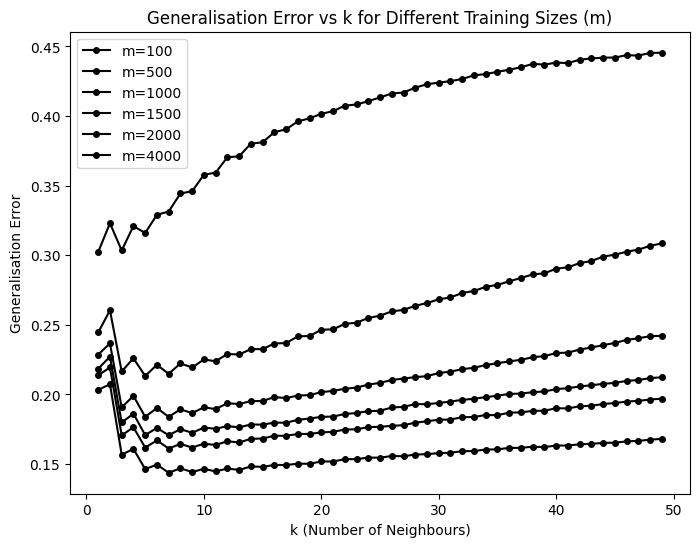

In [23]:
# Plotting generalisation error with original style for each m
plt.figure(figsize=(8, 6))
for m, errors in results.items():
    plt.plot(
        range(1, max_k + 1),
        errors,
        marker='o',
        markersize=4,
        label=f"m={m}",
        color='black'
    )
plt.xlabel('k (Number of Neighbours)')
plt.ylabel('Generalisation Error')
plt.title('Generalisation Error vs k for Different Training Sizes (m)')
plt.legend()
plt.grid(False)
plt.show()